In [1]:
# In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world, 
# at varying distances from the equator. To accomplish this, you'll be utilizing a simple Python library, 
# the OpenWeatherMap API, and a little common sense to create a representative model of weather across world cities.
# The first requirement is to create a series of scatter plots to showcase the following relationships:

# Temperature (F) vs. Latitude
# Humidity (%) vs. Latitude
# Cloudiness (%) vs. Latitude
# Wind Speed (mph) vs. Latitude

# After each plot, add a sentence or two explaining what the code is analyzing.
# The second requirement is to run linear regression on each relationship. This time, separate the plots 
# into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 
# degrees latitude):

# Northern Hemisphere - Temperature (F) vs. Latitude
# Southern Hemisphere - Temperature (F) vs. Latitude
# Northern Hemisphere - Humidity (%) vs. Latitude
# Southern Hemisphere - Humidity (%) vs. Latitude
# Northern Hemisphere - Cloudiness (%) vs. Latitude
# Southern Hemisphere - Cloudiness (%) vs. Latitude
# Northern Hemisphere - Wind Speed (mph) vs. Latitude
# Southern Hemisphere - Wind Speed (mph) vs. Latitude

# After each pair of plots, take the time to explain what the linear regression is modeling. 
# For example, describe any relationships you notice and any other analysis you may have.
# Your final notebook must:

# Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude.
# Perform a weather check on each of the cities using a series of successive API calls.
# Include a print log of each city as it's being processed with the city number and city name.
# Save a CSV of all retrieved data and a PNG image for each scatter plot.

In [2]:
# Import dependencies:

import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
from config import api_key
import time   #used for time.sleep

In [3]:
# Printed api key to ensure that it imported correctly
# print(api_key)

In [4]:
# Generate a random list of 500 unique cities with a reasonably even distribution across the globe

# Set a range for lat and lng that includes the whole Earth
# latitude range is -90 to 90, longitude range is -180 to 180
lats = []
longs = []

lats = np.random.uniform(-90, 90, 25)
longs = np.random.uniform(-180, 180, 25)

#print(lats)
#print(longs)

In [5]:
# zip lists together to form coordinates
lat_long = zip(lats, longs)
lat_long

In [6]:
#lat_long = pd.DataFrame(lat_long)
#lat_long

In [7]:
# Use citipy to find cities near coordinates

#Import citipy
from citipy import citipy

cities = []
countries = []

for lat_long in lat_long:
    city = citipy.nearest_city(lat_long[0], lat_long[1]).city_name
    country = citipy.nearest_city(lat_long[0], lat_long[1]).country_code
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        countries.append(country)

# Print the city count to confirm sufficient count
print(len(cities))
print(len(countries))

24
24


In [8]:
cities = [city.title() for city in cities]
countries = [country.upper() for country in countries]

In [9]:
# Build dataframe to hold data
weather_df = pd.DataFrame({"Cities" : cities, "Countries" : countries})
weather_df.head()

,Cities,Countries
0,Ponta Do Sol,CV
1,Nome,US
2,Qaanaaq,GL
3,Nemuro,JP
4,Ribeira Grande,PT


In [10]:
# Check for NaNs
weather_df.isnull().sum()

Cities       0
Countries    0
dtype: int64

In [11]:
# Add places to hold data for each city

weather_df["Latitude"] = ""
weather_df["Longitude"] = ""
weather_df["Temperature (F)"] = ""
weather_df["Humidity (%)"] = ""
weather_df["Cloudiness"] = ""
weather_df["Wind Speed (mph)"] = ""
weather_df.head()

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Ponta Do Sol,CV,,,,,,
1,Nome,US,,,,,,
2,Qaanaaq,GL,,,,,,
3,Nemuro,JP,,,,,,
4,Ribeira Grande,PT,,,,,,


In [12]:
# Use OpenWeather to get weather data for generated list of cities, test on one city

base_url = "http://api.openweathermap.org/data/2.5/weather?"
city_name = "Minneapolis"
country_code = "US"
query_url = f"{base_url}q={city_name},{country_code}&appid={api_key}&units=imperial"
#print(query_url) - test url worked
#minneapolis_weather = requests.get(query_url).json()
#minneapolis_weather

In [13]:
#test get lat
#minneapolis_weather["coord"]["lat"]

In [14]:
#test get long
#minneapolis_weather["coord"]["lon"]

In [15]:
#test get temp
#minneapolis_weather["main"]["temp"]

In [16]:
#test get humidity
#minneapolis_weather["main"]["humidity"]

In [17]:
#test get cloudiness
#minneapolis_weather["clouds"]["all"]
#cloudiness exists on a scale documented at https://openweathermap.org/weather-conditions

In [18]:
#test get windspeed
#minneapolis_weather["wind"]["speed"]

In [19]:
# Build a for loop to use the city names to call the OpenWeather API
# Test to ensure that the city has data, otherwise skip
# Generate a print log for each city as it is being processed

my_params = {"appid" : api_key, "units" : "imperial"}

for index, row in weather_df.iterrows():
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row["Cities"]
    country = row["Countries"]
    
    my_params['q'] = f'{city},{country}'
    
    #make request
    cities_weather = requests.get(base_url, params=my_params).json()
    print(index, city)
    try:
        weather_df.loc[index, "Latitude"] = cities_weather["coord"]["lat"]
    except KeyError:
        weather_df.loc[index, "Latitude"] = np.nan
        print("skip")
        continue
       
    weather_df.loc[index, "Longitude"] = cities_weather["coord"]["lon"]
    weather_df.loc[index, "Temperature (F)"] = cities_weather["main"]["temp"]
    weather_df.loc[index, "Humidity (%)"] = cities_weather["main"]["humidity"]
    weather_df.loc[index, "Cloudiness"] = cities_weather["clouds"]["all"]
    weather_df.loc[index, "Wind Speed (mph)"] = cities_weather["wind"]["speed"]
        
    time.sleep(1)
        

0 Ponta Do Sol
1 Nome
2 Qaanaaq
3 Nemuro
4 Ribeira Grande
5 Las Vegas
6 Beringovskiy
7 Hobart
8 Nizhneyansk
skip
9 Sherlovaya Gora
10 Safwah
skip
11 Taolanaro
skip
12 Hilo
13 Sao Filipe
14 Rikitea
15 Gedo
16 Belushya Guba
skip
17 Jamestown
18 Tiksi
19 Nuuk
20 Arraial Do Cabo
21 Emilio Carranza
22 Ushuaia
23 Bluff


In [20]:
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Ponta Do Sol,CV,17.1994,-25.0919,69.8,64,75,20.71
1,Nome,US,64.5011,-165.406,-5.39,84,1,4.07
2,Qaanaaq,GL,77.484,-69.3632,13.5,85,79,7.65
3,Nemuro,JP,43.3236,145.575,13.42,86,0,10.22
4,Ribeira Grande,PT,38.5167,-28.7,59,77,40,11.5
5,Las Vegas,US,36.175,-115.137,64.89,16,1,3.44
6,Beringovskiy,RU,63.05,179.317,0.43,89,100,14.61
7,Hobart,AU,-42.8794,147.329,54.93,54,40,12.66
8,Nizhneyansk,RU,NaN,,,,,
9,Sherlovaya Gora,RU,50.5667,116.25,-15.93,88,11,3.62


In [21]:
#Drop rows with missing values
weather_df.dropna(inplace=True)
weather_df.reset_index(drop=True, inplace=True)
weather_df

,Cities,Countries,Latitude,Longitude,Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph)
0,Ponta Do Sol,CV,17.1994,-25.0919,69.8,64,75,20.71
1,Nome,US,64.5011,-165.406,-5.39,84,1,4.07
2,Qaanaaq,GL,77.484,-69.3632,13.5,85,79,7.65
3,Nemuro,JP,43.3236,145.575,13.42,86,0,10.22
4,Ribeira Grande,PT,38.5167,-28.7,59,77,40,11.5
5,Las Vegas,US,36.175,-115.137,64.89,16,1,3.44
6,Beringovskiy,RU,63.05,179.317,0.43,89,100,14.61
7,Hobart,AU,-42.8794,147.329,54.93,54,40,12.66
8,Sherlovaya Gora,RU,50.5667,116.25,-15.93,88,11,3.62
9,Hilo,US,19.7297,-155.09,70.68,50,1,3.44


In [22]:
# Save a CSV file containing all weather data

weather_df.to_csv("cities_weather.csv", encoding='utf-8', index=False)

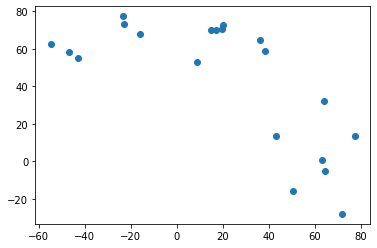

In [23]:
# Make a scatter plot to show relationship of temperature v latitude

x = weather_df["Latitude"]
y = weather_df["Temperature (F)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()


# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

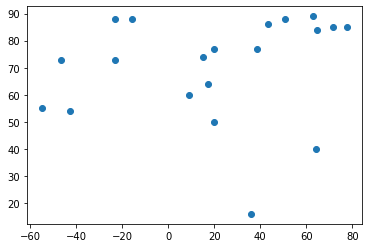

In [24]:
# Make a scatter plot to show the relationship of humidity v latitude

x = weather_df["Latitude"]
y = weather_df["Humidity (%)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

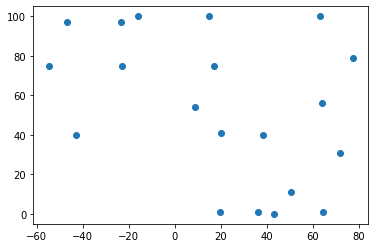

In [25]:
# Make a scatter plot to show the relationship of cloudiness v latitude

x = weather_df["Latitude"]
y = weather_df["Cloudiness"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file

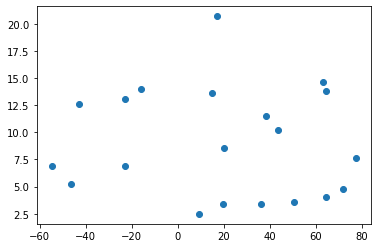

In [26]:
# Make a scatter plot to show the relationship of wind speed v latitude

x = weather_df["Latitude"]
y = weather_df["Wind Speed (mph)"]

temp_plt = plt.scatter(x, y, marker="o")

plt.show()

# After each plot, add a sentence or two explaining what the code is analyzing.
# Save plot as a PNG file